# CSP Features 

### Steps of FB-CSP Classification 
(Fast EEG-Based Decoding Of The Directional Focus Of Auditory Attention Using Common Spatial Patterns)
- Step 1: Filter Bank
    - 14(B is number of filter bank) 8th-order butterworth filters. The first filter corresponds to frequency band 1-4 hz. The second with 2-6. And continuous with overlap 2 hz until 26(2+12*2)-30 hz. 
- Step 2: CSP
    - How to choice the filter? RMOE (in this paper) vs. Covariance (mne, or common methods)
    - Choice k components from CSP filter
- Step 3: Log Energy
    - Summation the CSP pattern and calculate the log energy of every band and k filters
    - Output feature: Filter Bank B x k components
    - This step will be done by mne.decoding.csp.
- Step 4: Classification  
    - lda, svm

### Data pipline or workflow
Theres two task of the works. Binary classification vs. Multi-class
First in single classes
- Data Prepration: 
    - Input Data: 2(class) x 25(subjects) x 32/2(trials, unknown?) x channel num x trials timepoint
    - Output Data: channel num x 2(class) x segments numbers[subjects x trials x decision windows numbers] x decision windows size (4sec x 128hz)
- Step 1: Filter Bank
    - Input Data: (channel num, 2 x segments numbers, 512)
    - Ouput Data: 2, segments numbers, 14 bank num, 512
- Step 2: CSP
    - Input Data: (s)

### Step 1 - Data Prepration

In [12]:
import mne
import h5py
import numpy as np
import os
import scipy.io
import pandas as pd

# Variables
window_sec = 4
choice_direction = 90 # 0: 全選
bands = {
    '1': (12, 16),
    '2': (14, 18),
    '3': (16, 20),
    '4': (18, 22),
}
# for iter_ in range(4, 15):
#     pre_low, pre_high = bands[str(iter_-1)]
#     bands[str(iter_)] = (pre_low+2, pre_high+2)


# Load Data
path = "./NJUNCA_preprocessed_arte_removed/"
expinfo_path = path + "expinfomat_csvs/"
mat_files = [f for f in os.listdir(path) if f.endswith('.mat')]

subjects = 21
fs = 128  # sampling frequency
window_size = fs * window_sec  # 512
channels = 32  # assume full 32 channels
count = 0
side_dict = {
    "right": 0,
    "left": 1,
}


# Load data
all_segments = []
all_labels = []
all_trials = []
pre_trial_idx = 0



for subj in range(2, subjects):

    print(f"\n###  Subject: `{mat_files[subj].split('.')[0]}`")

    print("| Trial | Angle (L/R) | Segment Start~End |")
    print("|-------|-------------|-------------------|")

    data_path = path + mat_files[subj]
    file = h5py.File(data_path, 'r')
    csv_path = expinfo_path + mat_files[subj].replace('.mat', '.csv')
    df = pd.read_csv(csv_path)['attended_lr']

    ref_data = file['data']
    ref_eeg = ref_data['eeg']
    ref_leftangle = ref_data['event']['leftWav']
    ref_rightangle = ref_data['event']['rightWav']
    ref_attenside = ref_data['event']['eeg']
    trials = len(ref_eeg[:])

    for trial in range(trials):
        try:
            left_angel_reg = file[ref_leftangle['value'][trial][0]]
            left_angel = file[left_angel_reg[0][0]][0][0]
            right_angel_reg = file[ref_rightangle['value'][trial][0]]
            right_angel = file[right_angel_reg[0][0]][0][0]

            if (left_angel*-1) != right_angel:
                print(f"| {trial:<5} | {left_angel}/{right_angel:<7} | not the same angle |")
                continue
            # if abs(right_angel) != 90:
            #     print(f"{mat_files[subj]}-{trial}: {left_angel}/{right_angel} not 90 degree")
            #     continue
            print(f"| {trial:<5} | {left_angel}/{right_angel:<7} | {pre_trial_idx} ~ {count:<5} |")
            ref = ref_eeg[trial][0]
            eeg_data = np.array(file[ref][:]) # shape: 32, time
            trial_len = eeg_data.shape[1]
            
            # Segment into 4-second windows (non-overlapping)
            n_windows = trial_len // window_size
            
            for win in range(n_windows):
                segment = eeg_data[:, win * window_size : (win + 1) * window_size]  # shape: (channels, 512)
                count += 1
                all_segments.append(segment)
                all_labels.append(side_dict[df[trial]])
                
            # write trial info dict
            trial_info = {
                "subject_name": mat_files[subj].split('.')[0],
                "trial":trial,
                "attention_side": df[trial],
                "left_angel": left_angel,
                "right_angel": right_angel,
                "trial_start": pre_trial_idx,
                "trial_end": count,
            }
            all_trials.append(trial_info)
            pre_trial_idx = count 
        except:
            print(f"| {trial:<5} | {left_angel}/{right_angel:<7} | Load error!! |")
    print(f"\n**Total Segments ({mat_files[subj].split('.')[0]}):** {count}\n")



# Convert to numpy arrays
X = np.stack(all_segments)  # shape: (total_segments, channels, 512)
y = np.array(all_labels)    # shape: (total_segments,)

print("---\n")
print("** Dataset Summary**")
print(f"- **EEG Shape:** {X.shape}")
print(f"- **Labels Shape:** {y.shape}")

n_epochs, n_channels, n_times = X.shape
sfreq = 128  # sampling frequency

# 建立 channel info
# 你給的通道名稱
ch_names = [
    'Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
    'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 建立 event array
# MNE 的 events shape 是 (n_epochs, 3)，通常中間值無用
# 最後一欄是 class label，需要轉換成 event id 後對應 dict
events = np.column_stack((
    np.arange(len(y)),  # arbitrary sample indices
    np.zeros(len(y), dtype=int),  # filler
    y
))

# 建立 event_id 字典
event_id = {f'class_{i}': i for i in np.unique(y)}

# 轉成 EpochsArray
epochs = mne.EpochsArray(X, info, events=events, event_id=event_id, verbose=False)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

print("- **Epochs Info:**")
print(f"  - `Total Epochs:` {len(epochs)}")
for label, count_label in event_id.items():
    print(f"  - `{label}`: {(y == count_label).sum()}")
print(f"  - `Duration:` 0 – {X.shape[2] / sfreq:.3f} s")
print(f"  - `Memory:` ~{X.nbytes / (1024 ** 2):.1f} MB")


###  Subject: `S02`
| Trial | Angle (L/R) | Segment Start~End |
|-------|-------------|-------------------|
| 0     | -90.0/90.0    | 0 ~ 0     |
| 1     | -90.0/90.0    | 10 ~ 10    |
| 2     | -135.0/135.0   | 15 ~ 15    |
| 3     | -135.0/135.0   | 27 ~ 27    |
| 4     | 30.0/60.0    | not the same angle |
| 5     | 30.0/60.0    | not the same angle |
| 6     | 0.0/0.0     | 34 ~ 34    |
| 7     | 0.0/0.0     | 49 ~ 49    |
| 8     | -30.0/-90.0   | not the same angle |
| 9     | -30.0/-90.0   | not the same angle |
| 10    | 30.0/90.0    | not the same angle |
| 11    | 30.0/90.0    | not the same angle |
| 12    | -120.0/120.0   | 51 ~ 51    |
| 13    | -120.0/120.0   | 76 ~ 76    |
| 14    | -15.0/15.0    | 93 ~ 93    |
| 15    | -15.0/15.0    | 110 ~ 110   |
| 16    | -30.0/-60.0   | not the same angle |
| 17    | -30.0/-60.0   | not the same angle |
| 18    | -45.0/45.0    | 122 ~ 122   |
| 19    | -45.0/45.0    | 134 ~ 134   |
| 20    | -60.0/60.0    | 146 ~ 146   |
| 21    |

### Subject Group Training set and testing set

In [13]:
group_ = [(2, 7), (8, 15), (16, 19), (21, 23), (25, 27)]  # 5 groups
group_index_list = [[] for _ in range(len(group_))]      # list of 5 empty lists

cum_trials = 0 
for idx, info_dict in enumerate(all_trials):
    # print(f"{idx}-{info_dict['subject_name']}/{info_dict['trial']} - cumulated trials rate:{info_dict['trial_end']/count}")
    if choice_direction != 0:
        if abs(info_dict['left_angel']) != choice_direction:
            continue

    subject_int = int(info_dict['subject_name'].replace('S', ''))

    # 分配到對應的 group
    for group_id, (low, high) in enumerate(group_):
        if low <= subject_int <= high:
            trial_range = range(info_dict['trial_start'], info_dict['trial_end'])
            # print(info_dict['subject_name'], info_dict['trial'], info_dict['trial_start'], info_dict['trial_end'])
            cum_trials += len(trial_range)
            group_index_list[group_id].extend(trial_range)
            break
print(f"## Total Segments: {cum_trials}")
print("| Group | Subject Range | Segment Count | Segment Ratio (%) | Cumulated Ratio (%) |")
print("|-------|---------------|---------------|-------------------|---------------------|")
cum_ratio = 0
for idx, g_l in enumerate(group_index_list):
    trial_ratio = len(g_l) / cum_trials
    cum_ratio += trial_ratio
    low, high = group_[idx]
    print(f"| {idx+1}     | S{low:02d} ~ S{high:02d}     | {len(g_l):<13} | {trial_ratio*100:>8.1f}%         | {cum_ratio*100:>5.1f}%              |")



## Total Segments: 1172
| Group | Subject Range | Segment Count | Segment Ratio (%) | Cumulated Ratio (%) |
|-------|---------------|---------------|-------------------|---------------------|
| 1     | S02 ~ S07     | 163           |     13.9%         |  13.9%              |
| 2     | S08 ~ S15     | 151           |     12.9%         |  26.8%              |
| 3     | S16 ~ S19     | 165           |     14.1%         |  40.9%              |
| 4     | S21 ~ S23     | 368           |     31.4%         |  72.3%              |
| 5     | S25 ~ S27     | 325           |     27.7%         | 100.0%              |


### Step 2 - CSP and Log Power

In [14]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm, tree
from mne.decoding import CSP

def do_csp(bands, train_epochs, test_epochs, train_y, test_y):
    csp_list = []
    train_features = []
    test_features = []

    for name, (l_freq, h_freq) in bands.items():
        train_epochs_band = train_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)
        test_epochs_band = test_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)

        csp = CSP(n_components=4, reg='ledoit_wolf')
        train_csp = csp.fit_transform(train_epochs_band, train_y)
        test_csp = csp.transform(test_epochs_band)

        csp_list.append(csp)
        train_features.append(train_csp)
        test_features.append(test_csp)

    train_CSP_features = np.concatenate(train_features, axis=1)
    test_CSP_features = np.concatenate(test_features, axis=1)

    cv = ShuffleSplit(10, test_size=0.2, random_state=42)

    # Define classifiers
    lda = LinearDiscriminantAnalysis()
    svc = svm.SVC()
    dt = tree.DecisionTreeClassifier()

    # Cross-validation scores (optional, not used in return)
    _ = cross_val_score(svc, train_CSP_features, train_y, cv=cv)
    _ = cross_val_score(lda, train_CSP_features, train_y, cv=cv)
    _ = cross_val_score(dt, train_CSP_features, train_y, cv=cv)

    # Fit and predict
    svc.fit(train_CSP_features, train_y)
    lda.fit(train_CSP_features, train_y)
    dt.fit(train_CSP_features, train_y)

    svm_pred_y = svc.predict(test_CSP_features)
    lda_pred_y = lda.predict(test_CSP_features)
    dt_pred_y = dt.predict(test_CSP_features)

    return svm_pred_y, lda_pred_y, dt_pred_y, csp_list


### Step 3 - Do Leave one group out

In [15]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def leaveonegroupout(group_index, epochs, y, bands):
    pred_svm = []
    pred_lda = []
    pred_dt = []
    true_labels = []
    csp_list = []

    acc_svm_list, acc_lda_list, acc_dt_list = [], [], []
    f1_svm_list, f1_lda_list, f1_dt_list = [], [], []

    for valid_group in range(len(group_index)):
        print(f"--------------------------------------------------------------------------------------------------------------\n\n")
        print(f"\n\tGroup:{valid_group}\n")
        print(f"--------------------------------------------------------------------------------------------------------------\n\n")

        test_idx = group_index[valid_group]
        train_idx = [i for g, indices in enumerate(group_index) if g != valid_group for i in indices]

        train_epochs = epochs[train_idx].copy()
        test_epochs = epochs[test_idx].copy()
        train_y = y[train_idx]
        test_y = y[test_idx]

        temp_svm_pred_y, temp_lda_pred_y, temp_dt_pred_y, temp_csp_list = do_csp(bands, train_epochs, test_epochs, train_y, test_y)

        pred_svm.extend(temp_svm_pred_y)
        pred_lda.extend(temp_lda_pred_y)
        pred_dt.extend(temp_dt_pred_y)
        csp_list.extend(temp_csp_list)
        true_labels.extend(test_y)

        # Accuracy
        acc_svm = accuracy_score(test_y, temp_svm_pred_y)
        acc_lda = accuracy_score(test_y, temp_lda_pred_y)
        acc_dt = accuracy_score(test_y, temp_dt_pred_y)

        # F1
        f1_svm = f1_score(test_y, temp_svm_pred_y, average='macro')
        f1_lda = f1_score(test_y, temp_lda_pred_y, average='macro')
        f1_dt = f1_score(test_y, temp_dt_pred_y, average='macro')

        # Append to lists
        acc_svm_list.append(acc_svm)
        acc_lda_list.append(acc_lda)
        acc_dt_list.append(acc_dt)

        f1_svm_list.append(f1_svm)
        f1_lda_list.append(f1_lda)
        f1_dt_list.append(f1_dt)

    # Global metrics
    pred_svm = np.array(pred_svm)
    pred_lda = np.array(pred_lda)
    pred_dt = np.array(pred_dt)
    true_labels = np.array(true_labels)

    acc_svm_total = accuracy_score(true_labels, pred_svm)
    acc_lda_total = accuracy_score(true_labels, pred_lda)
    acc_dt_total = accuracy_score(true_labels, pred_dt)

    f1_svm_total = f1_score(true_labels, pred_svm, average='macro')
    f1_lda_total = f1_score(true_labels, pred_lda, average='macro')
    f1_dt_total = f1_score(true_labels, pred_dt, average='macro')

    # Std
    std_acc_svm = np.std(acc_svm_list)
    std_acc_lda = np.std(acc_lda_list)
    std_acc_dt = np.std(acc_dt_list)

    std_f1_svm = np.std(f1_svm_list)
    std_f1_lda = np.std(f1_lda_list)
    std_f1_dt = np.std(f1_dt_list)

    print("="*70)
    print(" Classification Results Summary")
    print("="*70)
    print(f"{'Model':<13}  | {'Accuracy':>9} | {'Std(acc)':>9} | {'F1-score':>9} | {'Std(F1)':>9}")
    print("-"*70)
    print(f"{'SVM':<13}  | {acc_svm_total:>9.3f} | {std_acc_svm:>9.3f} | {f1_svm_total:>9.3f} | {std_f1_svm:>9.3f}")
    print(f"{'LDA':<13}  | {acc_lda_total:>9.3f} | {std_acc_lda:>9.3f} | {f1_lda_total:>9.3f} | {std_f1_lda:>9.3f}")
    print(f"{'Decision Tree'}  | {acc_dt_total:>9.3f} | {std_acc_dt:>9.3f} | {f1_dt_total:>9.3f} | {std_f1_dt:>9.3f}")
    print("="*70)

    print("\n Group-wise Accuracy (per fold):")
    print(f"SVM           : {[round(a, 3) for a in acc_svm_list]}")
    print(f"LDA           : {[round(a, 3) for a in acc_lda_list]}")
    print(f"Decision Tree : {[round(a, 3) for a in acc_dt_list]}")

    
    return acc_svm_total, f1_svm, acc_lda_total, f1_lda, acc_dt_total, f1_dt, csp_list


### RUN FB CSP Classification 

In [16]:
_, _, _, _, _, _, csp_list = leaveonegroupout(group_index_list, epochs, y, bands)

--------------------------------------------------------------------------------------------------------------



	Group:0

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)


[Parallel(n_jobs=1)]: Done 32288 out of 32288 | elapsed:    5.4s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5216 out of 5216 | elapsed:    0.6s finished


    Using tolerance 88 (2.2e-16 eps * 32 dim * 1.2e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Done 32288 out of 32288 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5216 out of 5216 | elapsed:    0.5s finished


    Using tolerance 69 (2.2e-16 eps * 32 dim * 9.7e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Done 32288 out of 32288 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5216 out of 5216 | elapsed:    0.5s finished


    Using tolerance 65 (2.2e-16 eps * 32 dim * 9.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Done 32288 out of 32288 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5216 out of 5216 | elapsed:    0.4s finished


    Using tolerance 65 (2.2e-16 eps * 32 dim * 9.1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:1

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 32672 out of 32672 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 4832 out of 4832 | elapsed:    0.3s finished


    Using tolerance 90 (2.2e-16 eps * 32 dim * 1.3e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Done 32672 out of 32672 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 4832 out of 4832 | elapsed:    0.5s finished


    Using tolerance 71 (2.2e-16 eps * 32 dim * 1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Done 32672 out of 32672 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 4832 out of 4832 | elapsed:    0.4s finished


    Using tolerance 68 (2.2e-16 eps * 32 dim * 9.6e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Done 32672 out of 32672 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 4832 out of 4832 | elapsed:    0.4s finished


    Using tolerance 67 (2.2e-16 eps * 32 dim * 9.4e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:2

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 32224 out of 32224 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5280 out of 5280 | elapsed:    0.3s finished


    Using tolerance 80 (2.2e-16 eps * 32 dim * 1.1e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Done 32224 out of 32224 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5280 out of 5280 | elapsed:    0.4s finished


    Using tolerance 69 (2.2e-16 eps * 32 dim * 9.7e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Done 32224 out of 32224 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5280 out of 5280 | elapsed:    0.4s finished


    Using tolerance 67 (2.2e-16 eps * 32 dim * 9.4e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Done 32224 out of 32224 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5280 out of 5280 | elapsed:    0.4s finished


    Using tolerance 66 (2.2e-16 eps * 32 dim * 9.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:3

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 25728 out of 25728 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 11776 out of 11776 | elapsed:    1.0s finished


    Using tolerance 89 (2.2e-16 eps * 32 dim * 1.3e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Done 25728 out of 25728 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 11776 out of 11776 | elapsed:    1.2s finished


    Using tolerance 68 (2.2e-16 eps * 32 dim * 9.6e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Done 25728 out of 25728 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 11776 out of 11776 | elapsed:    1.1s finished


    Using tolerance 65 (2.2e-16 eps * 32 dim * 9.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Done 25728 out of 25728 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 11776 out of 11776 | elapsed:    1.1s finished


    Using tolerance 65 (2.2e-16 eps * 32 dim * 9.1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:4

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 27104 out of 27104 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 10400 out of 10400 | elapsed:    0.9s finished


    Using tolerance 88 (2.2e-16 eps * 32 dim * 1.2e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 121 samples (0.945 s)



[Parallel(n_jobs=1)]: Done 27104 out of 27104 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 10400 out of 10400 | elapsed:    1.0s finished


    Using tolerance 66 (2.2e-16 eps * 32 dim * 9.3e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 107 samples (0.836 s)



[Parallel(n_jobs=1)]: Done 27104 out of 27104 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 10400 out of 10400 | elapsed:    1.1s finished


    Using tolerance 62 (2.2e-16 eps * 32 dim * 8.8e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 95 samples (0.742 s)



[Parallel(n_jobs=1)]: Done 27104 out of 27104 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 10400 out of 10400 | elapsed:    1.0s finished


    Using tolerance 60 (2.2e-16 eps * 32 dim * 8.4e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
 Classification Results Summary
Model          |  Accuracy |  Std(acc) |  F1-score |   Std(F1)
----------------------------------------------------------------------
SVM            |     0.624 |     0.066 |     0.619 |     0.064
LDA            |     0.571 |     0.033 |     0.570 |     0.038
Decision Tree  |     0.571 |     0.063 |     0.566 |     0.095

 Group-wise Accuracy (per fold):
SVM           : [0.571, 0.682, 0.515, 0.614, 0.689]
LDA           : [0.589, 0.636, 0.57, 0.533, 0.575]
Decision Tree : [0.485, 0.583, 0.679, 0.549, 0.578]


### Plot CSP

				 Group 1
			 Filter Band: (12, 16)


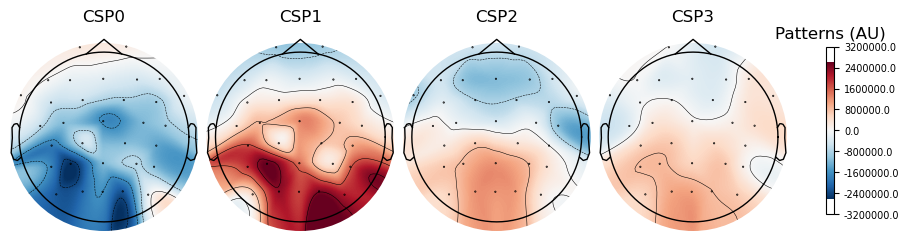

				 Group 1
			 Filter Band: (14, 18)


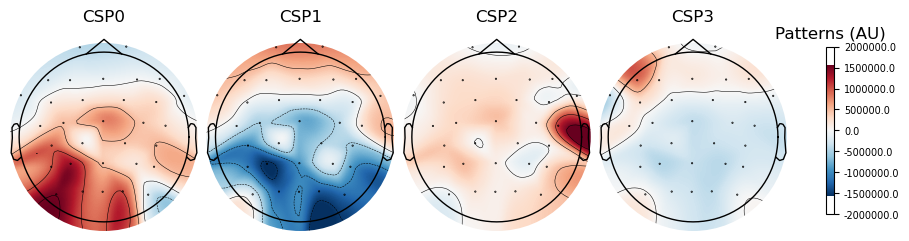

				 Group 1
			 Filter Band: (16, 20)


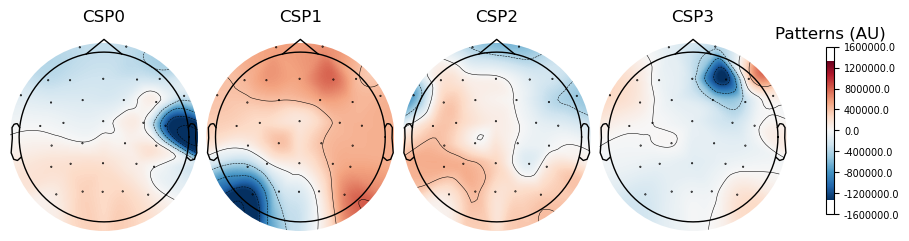

				 Group 1
			 Filter Band: (18, 22)


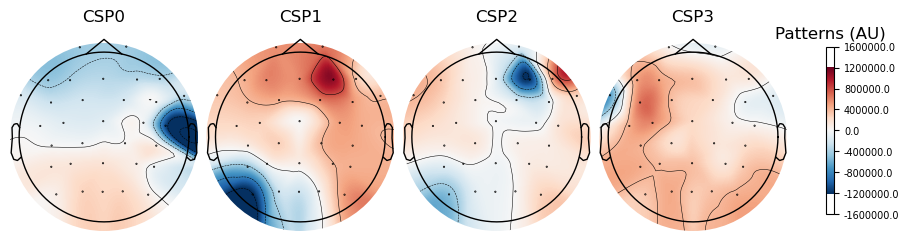

				 Group 2
			 Filter Band: (12, 16)


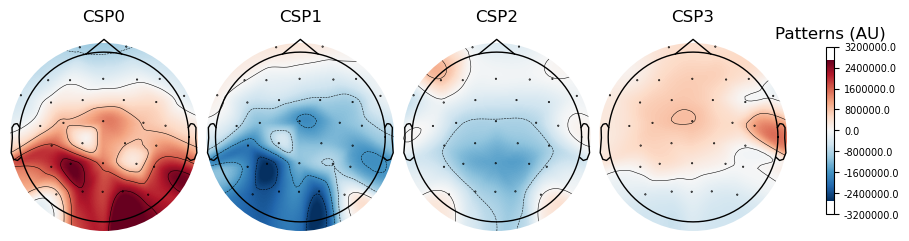

				 Group 2
			 Filter Band: (14, 18)


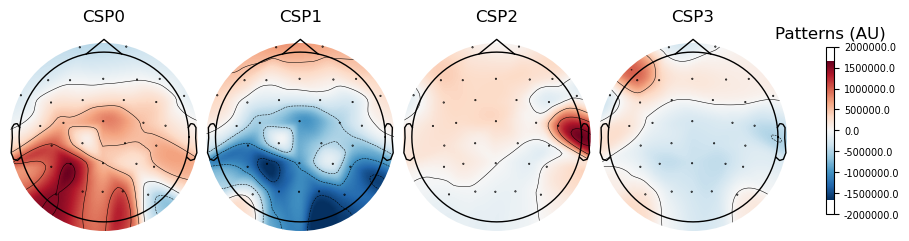

				 Group 2
			 Filter Band: (16, 20)


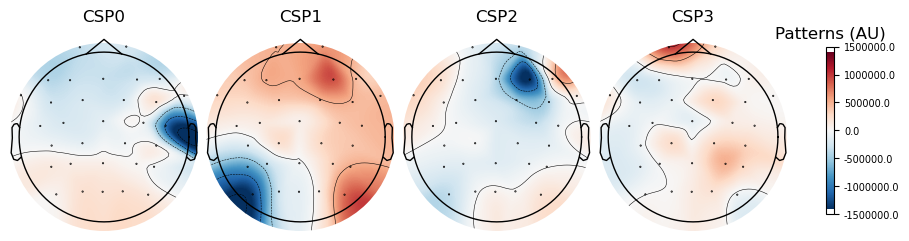

				 Group 2
			 Filter Band: (18, 22)


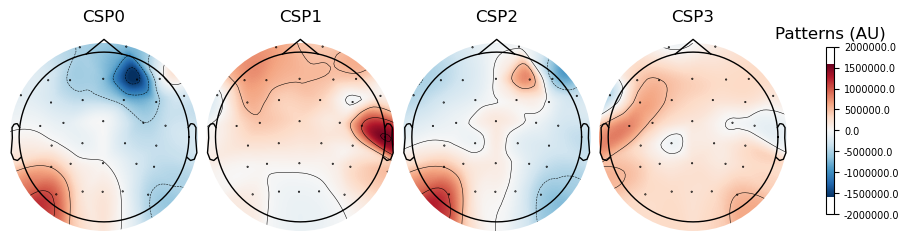

				 Group 3
			 Filter Band: (12, 16)


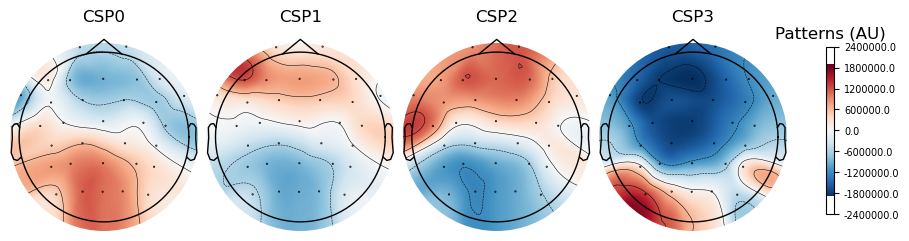

				 Group 3
			 Filter Band: (14, 18)


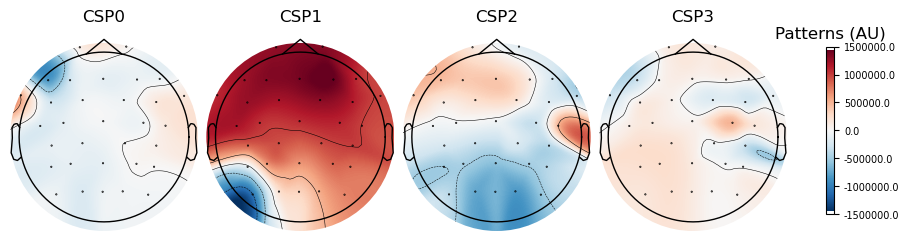

				 Group 3
			 Filter Band: (16, 20)


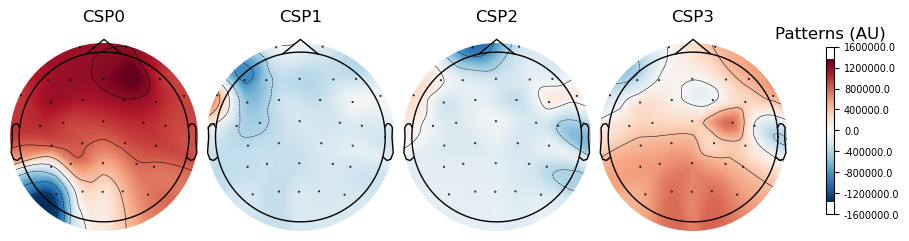

				 Group 3
			 Filter Band: (18, 22)


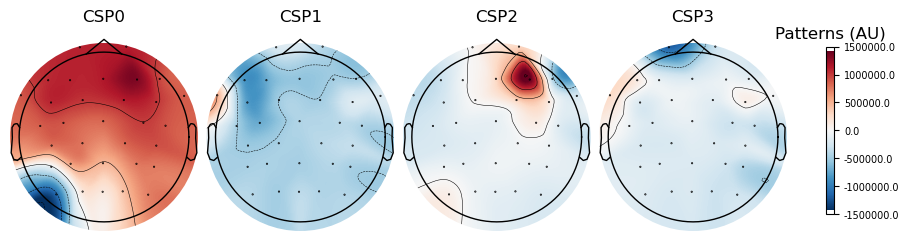

				 Group 4
			 Filter Band: (12, 16)


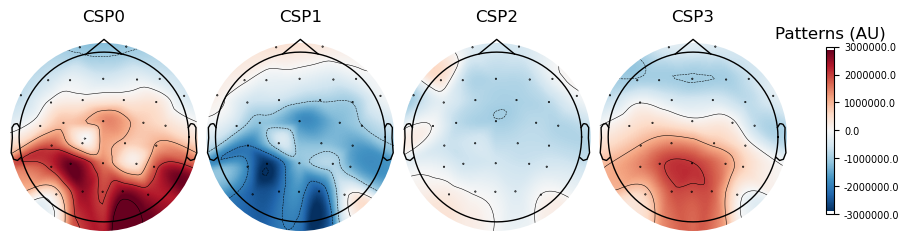

				 Group 4
			 Filter Band: (14, 18)


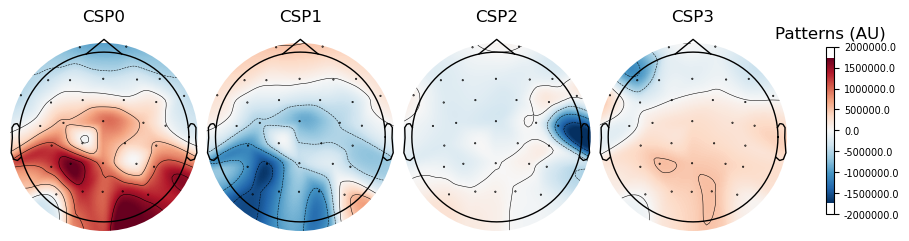

				 Group 4
			 Filter Band: (16, 20)


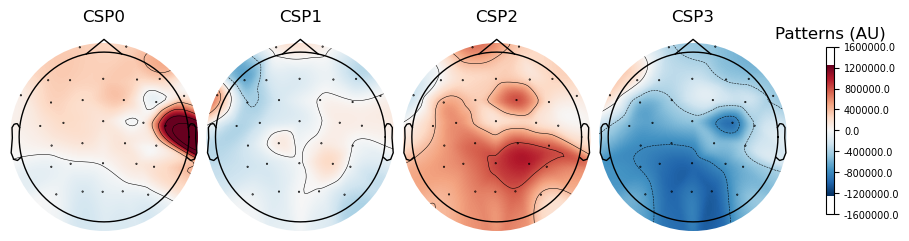

				 Group 4
			 Filter Band: (18, 22)


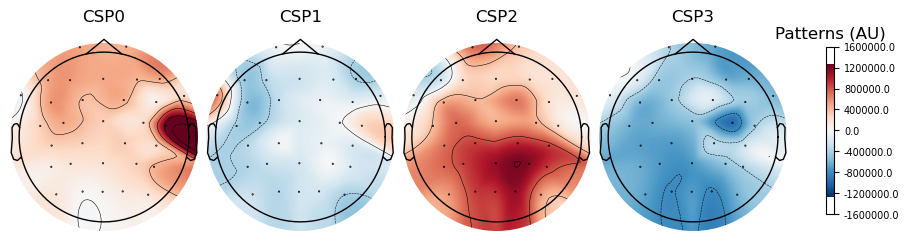

				 Group 5
			 Filter Band: (12, 16)


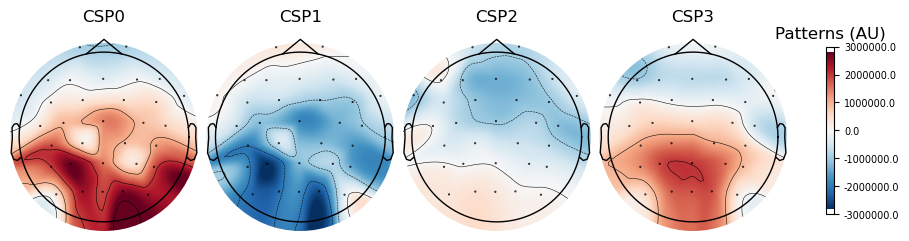

				 Group 5
			 Filter Band: (14, 18)


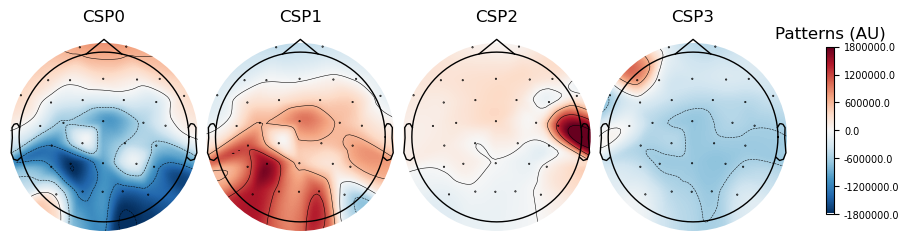

In [ ]:
for idx, csp in enumerate(csp_list):
    print("="*100)
    print(f"\t\t\t\t Group {int(idx/len(bands))+1}")
    print(f"\t\t\t Filter Band: {bands[str((idx)%len(bands)+1)]}")
    print("="*100)
    csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

### Mulit-class CSP
- 